### Implementation of Finetuning SAM2 for Leaf Disease Segmentation from [OpenCV](https://learnopencv.com/finetuning-sam2/#aioseo-data-preprocessing-and-visualization)

## Installing SAM2

In [ ]:
# # Clone the correct repository
# !git clone https://github.com/facebookresearch/segment-anything-2.git

# # Change directory
# %cd segment-anything-2

# # Install in editable mode
# !pip install -e .


Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cach

In [ ]:
# # Download SAM2 tiny model checkpoint (.pt file)
# # This is the smallest variant suitable for testing and local GPU usage
# !wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
# # -O flag: Forces wget to save the downloaded file with the specified name (sam2_hiera_tiny.pt)


--2025-02-11 07:10:57--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.15, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   109MB/s    in 1.4s    

2025-02-11 07:10:58 (109 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]



# Finetuning SAM2 - Imports and Setups

The custom modules build_sam2 and SAM2ImagePredictor are imported from the cloned SAM2, where build_sam2 sets up the network architecture with our chosen checkpoint, and SAM2ImagePredictor loads the model for further processing.

In [ ]:
import os
import random
import pandas as pd
import cv2
import torch
import torch.nn.utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



# Setting the Seed for Reproducibility

For deterministic results and reproducibility, we will set a fixed seed value to ensure consistent runs across different runs. This is a very common strategy for Finetuning SAM2 or any other model

In [ ]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    # # For MPS (Metal) device on Mac
    # if torch.backends.mps.is_available():
    #     torch.mps.manual_seed(SEED_VALUE)

    #For CUDA device (commented out for Mac Metal usage)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()


In [ ]:
torch.cuda.is_available()

True

Mounting goog drive as dataset was not being uploaded to content

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Loading and Splitting

In this segment, we start by defining file paths to our dataset directories. The CSV file, train.csv, holds metadata pairing images (`imageid`) with their masks (`maskid`). We use train_test_split from scikit-learn to partition our data into training and testing sets, allocating 80% to training and 20% to validating. Each entry in train_data and test_data is a dictionary containing the file paths for the corresponding image and mask, enabling easy iteration during training and validation.

In [ ]:
#Change data_dir to the path of the leaf-seg folder
data_dir = "D:\ANAND\SAM2_leaf_tutorial\SAM2_Leaf_Disease_Segmentation-main\SAM2_Leaf_Disease_Segmentation-main\leaf-seg" # remember to change this path guyzes
image_dir = os.path.join(data_dir, "images")
mask_dir = os.path.join(data_dir, "masks")

train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_data = []
for index, row in train_df.iterrows():
   image_name = row['imageid']
   mask_name = row['maskid']
   train_data.append({
       "image": os.path.join(image_dir, image_name),
       "annotation": os.path.join(mask_dir, mask_name)
   })

test_data = []
for index, row in test_df.iterrows():
   image_name = row['imageid']
   mask_name = row['maskid']
   test_data.append({
       "image": os.path.join(image_dir, image_name),
       "annotation": os.path.join(mask_dir, mask_name)
   })

# Data Preprocessing and Visualization

This function takes a random sample from our dataset, loads and resizes the image and mask into (1024 x 1024) as SAM2 expects this default size for training, and consolidates the mask into a single binary representation. Discuss about the random points being generated

 We apply light erosion on the mask to prevent sampling prompt points on boundary regions, which can sometimes confuse the mode

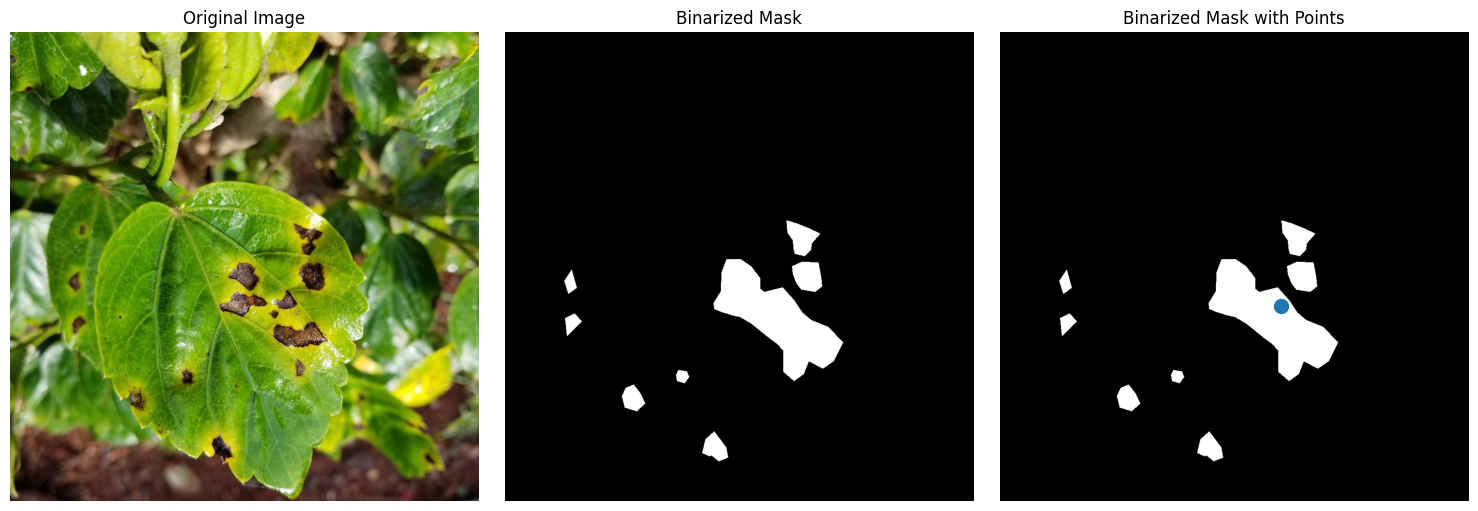

In [ ]:
def read_batch(data, visualize_data=True):
   ent = data[np.random.randint(len(data))] #ent = entry is a random element from the data
   Img = cv2.imread(ent["image"])[..., ::-1]  # Read the image and convert from BGR to RGB ([..., ::-1] reverses the last dimension)
   ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE) # Read the annotation mask as grayscale

   # Check if the image and mask are read correctly
   if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0

   r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
   Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),
                        interpolation=cv2.INTER_NEAREST)


   binary_mask = np.zeros_like(ann_map, dtype=np.uint8)  # creating a binary mask
   points = [] # intializing a list of points to store the points of the mask to be given to model as prompts
   inds = np.unique(ann_map)[1:] # find unique indices in the annotation map
   for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)
       binary_mask = np.maximum(binary_mask, mask)

# Eroding the Mask and Generating Points
#    Finds the coordinates (coords) of all non-zero pixels in the eroded mask.
# If there are any coordinates, randomly selects a point from the eroded mask for each unique index in the annotation map and adds it to the list of points (points).

   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
   coords = np.argwhere(eroded_mask > 0)
   if len(coords) > 0:
       for _ in inds:
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])
   points = np.array(points)

   # Data_viz if true will display the image, binary mask and binary mask with points
   if visualize_data:
       plt.figure(figsize=(15, 5))
       plt.subplot(1, 3, 1)
       plt.title('Original Image')
       plt.imshow(Img)
       plt.axis('off')

       plt.subplot(1, 3, 2)
       plt.title('Binarized Mask')
       plt.imshow(binary_mask, cmap='gray')
       plt.axis('off')

       plt.subplot(1, 3, 3)
       plt.title('Binarized Mask with Points')
       plt.imshow(binary_mask, cmap='gray')
       colors = list(mcolors.TABLEAU_COLORS.values())
       for i, point in enumerate(points):
           plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
       plt.axis('off')

       plt.tight_layout()
       plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)
   return Img, binary_mask, points, len(inds)

Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

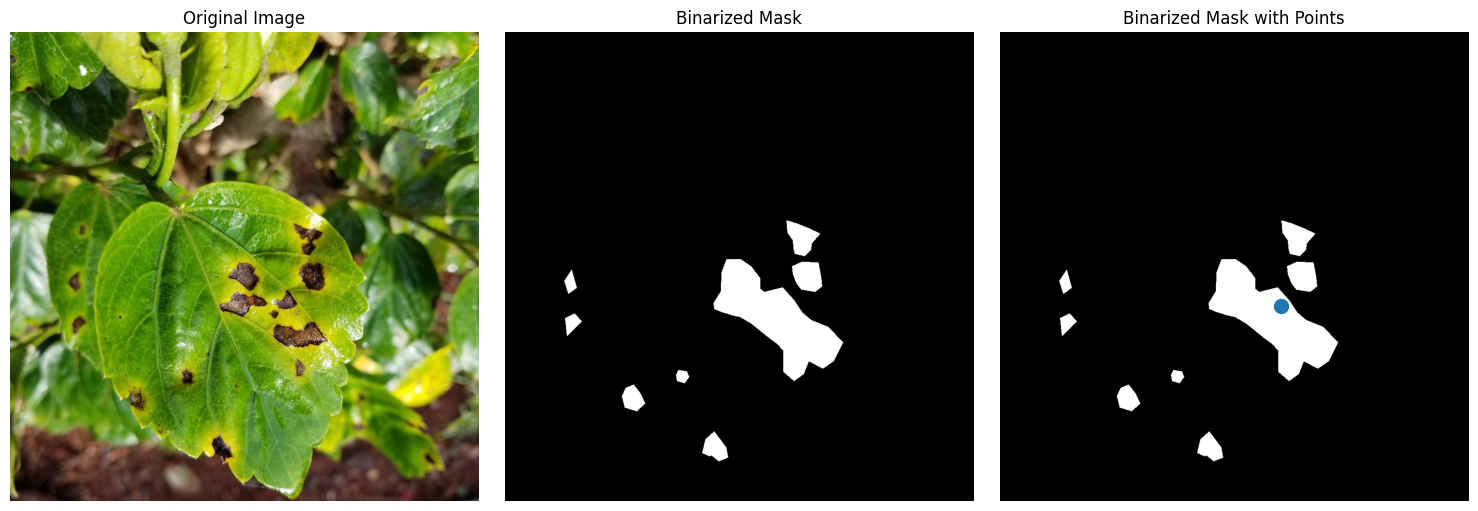

In [ ]:
def read_batch(data, visualize_data=True):
   ent = data[np.random.randint(len(data))] #ent = entry is a random element from the data
   Img = cv2.imread(ent["image"])[..., ::-1]  # Read the image and convert from BGR to RGB ([..., ::-1] reverses the last dimension)
   ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE) # Read the annotation mask as grayscale

   # Check if the image and mask are read correctly
   if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0

   r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])
   Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),
                        interpolation=cv2.INTER_NEAREST)


   binary_mask = np.zeros_like(ann_map, dtype=np.uint8)  # creating a binary mask
   points = [] # intializing a list of points to store the points of the mask to be given to model as prompts
   inds = np.unique(ann_map)[1:] # find unique indices in the annotation map
   for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)
       binary_mask = np.maximum(binary_mask, mask)

# Eroding the Mask and Generating Points
#    Finds the coordinates (coords) of all non-zero pixels in the eroded mask.
# If there are any coordinates, randomly selects a point from the eroded mask for each unique index in the annotation map and adds it to the list of points (points).

   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
   coords = np.argwhere(eroded_mask > 0)
   if len(coords) > 0:
       for _ in inds:
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])
   points = np.array(points)

   # Data_viz if true will display the image, binary mask and binary mask with points
   if visualize_data:
       plt.figure(figsize=(15, 5))
       plt.subplot(1, 3, 1)
       plt.title('Original Image')
       plt.imshow(Img)
       plt.axis('off')

       plt.subplot(1, 3, 2)
       plt.title('Binarized Mask')
       plt.imshow(binary_mask, cmap='gray')
       plt.axis('off')

       plt.subplot(1, 3, 3)
       plt.title('Binarized Mask with Points')
       plt.imshow(binary_mask, cmap='gray')
       colors = list(mcolors.TABLEAU_COLORS.values())
       for i, point in enumerate(points):
           plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)
       plt.axis('off')

       plt.tight_layout()
       plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)
   return Img, binary_mask, points, len(inds)

Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

Finally, we rearrange the mask into the shape (1, H, W) and the points into the shape (num_points, 1, 2), preparing them for input into the SAM2 model. This will be our structure of the training batch [input image, mask, the points, and the number of seg masks] for finetuning SAM2, and this is the finest approach to train SAM2 very quickly, with less computational expenses.

# Finetuning SAM2 - Building the SAM2 model
Here, we specify the paths to the pre-trained checkpoint (sam2_hiera_tiny.pt) and the matching model configuration (sam2_hiera_t.yaml). By initializing build_sam2 with these paths, we instantiate the core SAM2 model on the GPU. The SAM2ImagePredictor class is then created to manage prompts and predictions conveniently. Setting sam_mask_decoder and sam_prompt_encoder to training mode ensures that the relevant layers can be fine-tuned when we start our optimization routine

In [ ]:
# sam2_checkpoint = "/Users/anand/Github_project_portfolio/Finetune SAM2 for Leaf Disease Detection/sam2_hiera_tiny.pt" # do not put the downloaded checkpoint inside the segment-anything-2 folder
sam2_checkpoint = "D:\ANAND\SAM2_leaf_tutorial\SAM2_Leaf_Disease_Segmentation-main\SAM2_Leaf_Disease_Segmentation-main\sam2_hiera_tiny.pt"
model_cfg = "D:\ANAND\SAM2_leaf_tutorial\SAM2_Leaf_Disease_Segmentation-main\SAM2_Leaf_Disease_Segmentation-main\segment-anything-2\sam2\configs\sam2\sam2_hiera_t.yaml"

# device = mps for Metal device on Mac
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # !!!! Change device if running on a pc with GPU !!!!!
predictor = SAM2ImagePredictor(sam2_model)

# Train Mask Decoder
predictor.model.sam_mask_decoder.train(True)

# Train Prompt Encoder
predictor.model.sam_prompt_encoder.train(True)


PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

# Training Configuration for Finetuning SAM2

To speed up training and potentially reduce memory consumption, we use mixed precision through PyTorch’s **GradScaler**. We define the total number of training steps and a model name for saving our checkpoints. We have chose  **AdamW** as optimizer, combined with a step learning rate scheduler that reduces the learning rate by a factor **(gamma=0.6)** every certain number of steps **(step_size=2000)**.

When setting up the training loop, we have to know about **a few essential parameters** that control how the model learns from the data. These parameters influence how quickly or slowly the model converges, how stable the optimization process is, and ultimately how well the model performs on unseen data. Let’s take a closer look at these tunable parameters and what they do:

**Weight Decay (weight_decay = 1e-4)** – This parameter adds a penalty to large weights, helping prevent overfitting (type of regularization). It’s particularly useful when the model is prone to memorize the training data rather than generalizing to new inputs.

**Gamma (gamma = 0.6)** – The gamma value determines the scale of each learning rate reduction. A lower gamma results in a more significant drop in the learning rate, helping fine-tune the model’s parameters more precisely during later stages of training.

**Gradient Accumulation Steps (accumulation_steps = 8)** – Instead of updating the model’s weights after every mini-batch, this setting allows the optimizer to wait until gradients from multiple mini-batches are accumulated before performing an update. This effectively simulates a larger batch size, which can be beneficial when memory is limited.

Together, these parameters provide a fine level of control over the training process, making it possible to achieve better performance by carefully adjusting each one. Our primary goal is to achieve the best accuracy by tuning these hyperparameters for finetuning SAM2.

In [ ]:
scaler = torch.amp.GradScaler()
NO_OF_STEPS = 8000
FINE_TUNED_MODEL_NAME = "optimized_fine_tuned_sam"

# Optimizer Configuration
# optimizer = torch.optim.AdamW(params=predictor.model.parameters(),
#                              lr=1e-4,  # Increased initial learning rate
#                              weight_decay=0.05,  # Higher weight decay for regularization
#                              betas=(0.9, 0.999))
# tried optimizing LR scheduler
# Scheduler Configuration (Cosine Annealing with Warm Restarts)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=2000,        # Restart every 800 steps
#     T_mult=1,       # Keep cycle length constant
#     eta_min=1e-6    # Minimum learning rate
# )

# Training Parameters
# accumulation_steps = 16  # Reduced accumulation for more frequent updates
# max_grad_norm = 1.0      # Gradient clipping threshold

In [ ]:
# Opencv tutorial value
# optimizer = torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-4, weight_decay = 1e-4) #1e-5, weight_decay = 4e-5
optimizer = torch.optim.AdamW(params=predictor.model.parameters(),
                              lr=5e-5, #1e-5
                              weight_decay=4e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.6) # 500 , 250, gamma = 0.1
accumulation_steps = 8

# Finetuning SAM2 – Training and Validation Loops


In the training function, we start by reading a single random batch (which, in our example, is essentially one image-mask pair at a time). We create a foreground label (input_label = 1) for each set of prompt points. The predictor first encodes the image, then encodes the prompts (_prep_prompts), and finally feeds these embeddings into sam_mask_decoder to obtain the predicted masks.

The model processes these inputs in two main stages: prompt encoding and mask decoding.

First, the prompt encoder takes the input prompt points and their labels (which indicate foreground or background) and encodes them into dense and sparse embeddings. Sparse embeddings are derived from the specific locations of the points, capturing spatial information at a fine level. Dense embeddings, on the other hand, provide a broader representation of the image and the prompts by embedding them into a continuous feature space. This twofold approach allows the model to use precise location data from sparse embeddings while also benefiting from the general contextual information in the dense embeddings.

Once the embeddings are prepared, they are passed to the mask decoder, which generates segmentation masks. The decoder uses these embeddings, along with stored image features and positional encodings, to predict a set of low-resolution masks. These masks are then upsampled and compared against the ground-truth mask using a segmentation loss function. The entire process is designed to refine the model’s ability to correctly identify and segment regions of interest based on the provided point prompts.

Then, we compute two main losses: a binary cross-entropy (BCE) based segmentation loss and a score loss that tries to match the model’s predicted score (essentially a confidence measure) to the ground-truth IoU of the predicted mask. We then divide the loss by accumulation_steps to accumulate gradients over multiple forward passes. After scaling the loss using scaler.scale, we backprop through the network, clip gradients if they exceed a certain norm, and then update the optimizer every time we complete accumulation_steps mini-batches. We also update our learning rate scheduler and maintain a running average of IoU to monitor performance over time.

## Training Function:

In [ ]:
# device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")

def train(predictor, train_data, step, mean_iou):
    with torch.amp.autocast(device_type='cuda'):   #!!!!!!! changed device to mps from cuda !!!!!!!!!
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)

        if image is None or mask is None or num_masks == 0:
            return

        input_label = np.ones((num_masks, 1))

        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            return

        if input_point.size == 0 or input_label.size == 0:
            return

        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        ) #Sets the image in the predictor and prepares prompts for the model.

        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
            return

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(  # Generates sparse and dense embeddings using the prompt encoder.
            points=(unnorm_coords, labels), boxes=None, masks=None
        )
        #  Checks if batched mode is enabled and prepares high-resolution features.
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        # Generates low-resolution masks, prediction scores, and other outputs using the mask decoder.
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
        # Post-processes the low-resolution masks to generate the final predicted masks.
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()  #!!!!!!!!! move gt_masks .to(device) instead of .cuda() !!!!!!!!!!!!
        prd_mask = torch.sigmoid(prd_masks[:, 0]).cuda()  # !!!!!! moving prd_mask .to(device) instead of .cuda() !!!!!!!!!!!!

        seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)

        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        #clipping gradients
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()

        scheduler.step()

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"Step {step}: Current LR = {current_lr:.6f}, IoU = {mean_iou:.6f}, Seg Loss = {seg_loss:.6f}")
    return mean_iou

## Validation Function:

In [ ]:
def validate(predictor, test_data, step, mean_iou):
    predictor.model.eval()
    with torch.amp.autocast(device_type='cuda'):   #!!!!!!! changed device to mps from cuda !!!!!!!!!
        with torch.no_grad():  # Disable gradient computation for validation
            image, mask, input_point, num_masks = read_batch(test_data, visualize_data=False)

            if image is None or mask is None or num_masks == 0:
                return

            input_label = np.ones((num_masks, 1))

            if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
                return

            if input_point.size == 0 or input_label.size == 0:
                return

            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point, input_label, box=None, mask_logits=None, normalize_coords=True
            ) #Sets the image in the predictor and prepares prompts for the model.

            if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
                return

            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            ) # Generates sparse and dense embeddings using the prompt encoder.

            batched_mode = unnorm_coords.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]] # Prepares high-resolution features.
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            ) # Generates low-resolution masks and prediction scores.

            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1]) # Post-processes the low-resolution masks.

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()  #!!!!!!!!! move gt_masks .to(device) instead of .cuda() !!!!!!!!!!!!
            prd_mask = torch.sigmoid(prd_masks[:, 0]).cuda()  # !!!!!! moving prd_mask .to(device) instead of .cuda() !!!!!!!!!!!!

            seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6)
                        - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean() # Calculates segmentation loss.

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter) # Calculates IoU.

            score_loss = torch.abs(prd_scores[:, 0] - iou).mean() # Calculates score loss.
            loss = seg_loss + score_loss * 0.05 # Combines segmentation and score losses.
            loss = loss / accumulation_steps  # Retained from OpenCV docs

            if step % 500 == 0:  # Retained model saving logic from OpenCV docs
                FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".pt"
                torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy()) # Updates mean IoU.

            if step % 100 == 0:
                current_lr = optimizer.param_groups[0]["lr"]  # Retained from OpenCV docs
                print(f"Step {step}: Current LR = {current_lr:.6f}, Valid_IoU = {mean_iou:.6f}, Valid_Seg Loss = {seg_loss:.6f}")
    return mean_iou


# Running the Training

In [ ]:
train_mean_iou = 0
valid_mean_iou = 0

for step in range(1, NO_OF_STEPS + 1):
    train_mean_iou = train(predictor, train_data, step, train_mean_iou)
    valid_mean_iou = validate(predictor, test_data, step, valid_mean_iou)

Step 100: Current LR = 0.000050, IoU = 0.413225, Seg Loss = 0.034032
Step 100: Current LR = 0.000050, Valid_IoU = 0.419791, Valid_Seg Loss = 0.017830
Step 200: Current LR = 0.000050, IoU = 0.544640, Seg Loss = 0.257021
Step 200: Current LR = 0.000050, Valid_IoU = 0.562414, Valid_Seg Loss = 0.035924
Step 300: Current LR = 0.000050, IoU = 0.600093, Seg Loss = 0.130226
Step 300: Current LR = 0.000050, Valid_IoU = 0.623077, Valid_Seg Loss = 0.157713
Step 400: Current LR = 0.000050, IoU = 0.618387, Seg Loss = 0.073433
Step 400: Current LR = 0.000050, Valid_IoU = 0.641657, Valid_Seg Loss = 0.145983
Step 500: Current LR = 0.000050, IoU = 0.647889, Seg Loss = 0.192802
Step 500: Current LR = 0.000050, Valid_IoU = 0.633847, Valid_Seg Loss = 0.491376
Step 600: Current LR = 0.000050, IoU = 0.633851, Seg Loss = 0.091018
Step 600: Current LR = 0.000050, Valid_IoU = 0.648228, Valid_Seg Loss = 0.083506
Step 700: Current LR = 0.000050, IoU = 0.637323, Seg Loss = 0.035101
Step 700: Current LR = 0.000050

# Inference Pipeline

In [ ]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [ ]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
print(selected_entry)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)


{'image': 'D:\\ANAND\\SAM2_leaf_tutorial\\SAM2_Leaf_Disease_Segmentation-main\\SAM2_Leaf_Disease_Segmentation-main\\leaf-seg\\images\\00104.jpg', 'annotation': 'D:\\ANAND\\SAM2_leaf_tutorial\\SAM2_Leaf_Disease_Segmentation-main\\SAM2_Leaf_Disease_Segmentation-main\\leaf-seg\\masks\\00104.png'}
D:\ANAND\SAM2_leaf_tutorial\SAM2_Leaf_Disease_Segmentation-main\SAM2_Leaf_Disease_Segmentation-main\leaf-seg\masks\00104.png mask path


In [ ]:

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "D:\ANAND\SAM2_leaf_tutorial\SAM2_Leaf_Disease_Segmentation-main\SAM2_Leaf_Disease_Segmentation-main\optimized_fine_tuned_sam_8000.pt"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))





<All keys matched successfully>

## Perform inference and predict masks

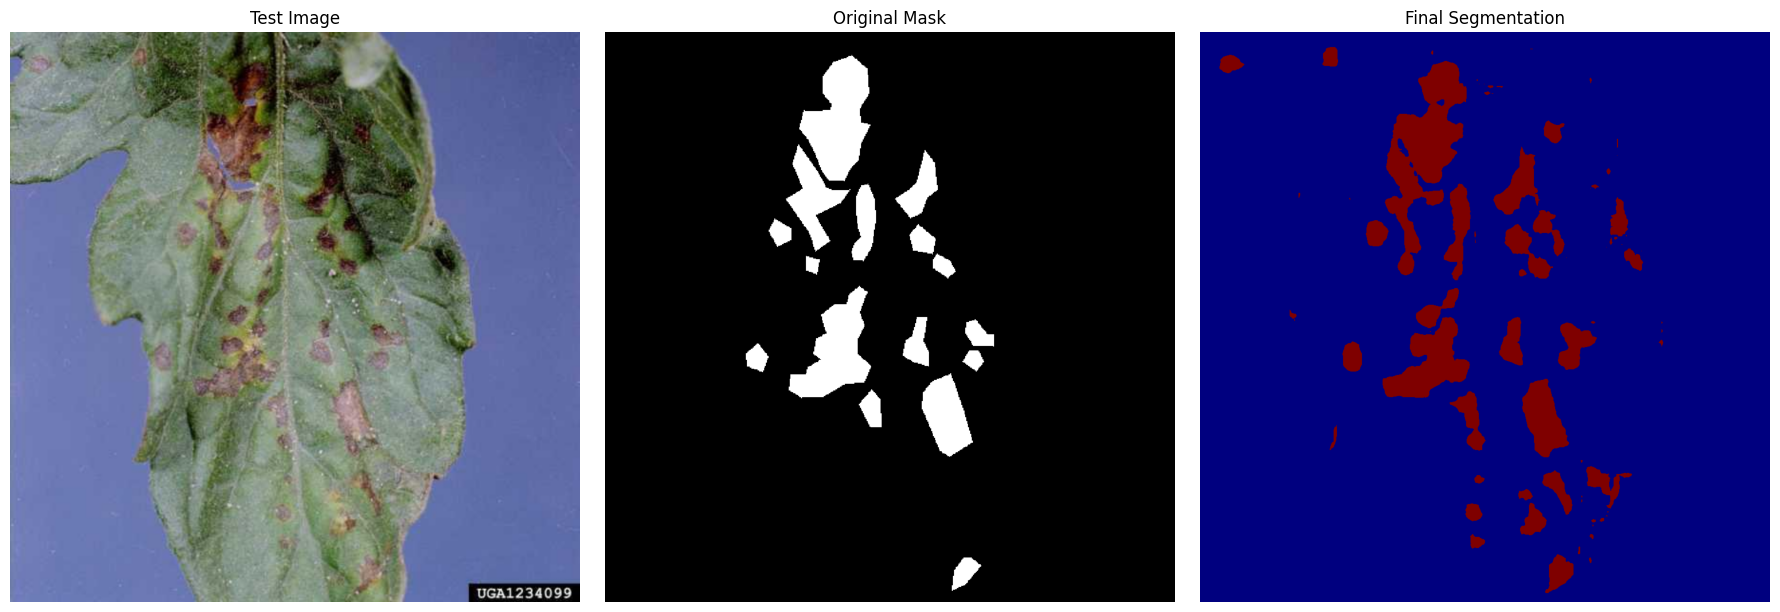

In [ ]:

with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

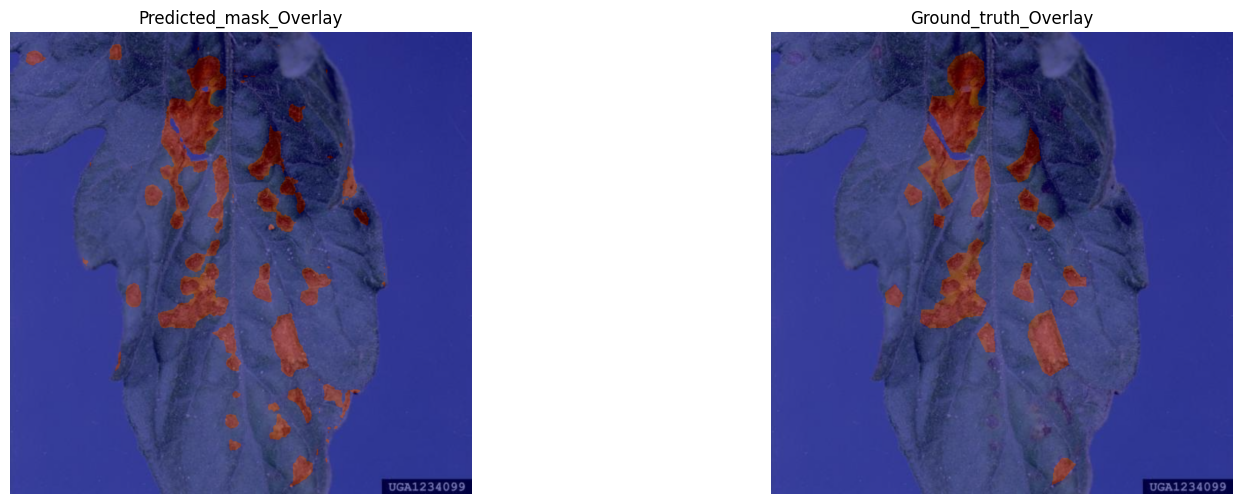

In [ ]:
# Visualizaing the Groundtruth_Overlay and Predicted_mask_Overlay

plt.figure(figsize=(18, 6))

plt.subplot(1,2,2)
plt.title("Ground_truth_Overlay")
plt.imshow(image)
plt.imshow(target_mask, alpha=0.5, cmap='jet')
plt.axis('off')

plt.subplot(1,2,1)
plt.title("Predicted_mask_Overlay")
plt.imshow(image)
plt.imshow(seg_map, alpha=0.5, cmap='jet')
plt.axis('off')